# Logitstic Regression

In [1]:
import pandas as pd
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from src.logreg import LogReg
import src.utils as utils

### Without outliers

In [2]:
df = pd.read_csv("data/diamonds.csv")
X_train, X_test, y_train, y_test = utils.preprocessing_LOS(df)

First, we train a Logistic Regression with the default parameters, and see what is capable of.  
Note: L2 (Ridge) Regularization is used.

In [3]:
model = LogReg()
model.cross_validation(X_train, y_train, 5, 0.2)

Performing cross validation


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    5.7s remaining:    8.6s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    5.8s remaining:    3.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.8s finished


Cross validation (accuracy) scores:
	mean: 0.6880010618529334 std: 0.0020017406447049523


In [4]:
X_train2, X_val, y_train2, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
model.fit(X_train2, y_train2)
model.compute_metrics(X_val, y_val)

{'accuracy': 0.6882134324396071,
 'precision': 0.6717639607649641,
 'recall': 0.5049496024195845,
 'f1': 0.5236486703690195}

Not bad for a simple model, but an exploration on the best hyperparameters will certainly improve these metrics.  
First, let's make sure regularization made a good job by showing the values of the coefficients (the weights).

Total number of weights: 45, (9 per class)


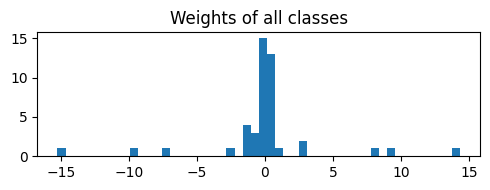

In [5]:
import matplotlib.pyplot as plt
import numpy as np

weights = model.coef_

weights_flattened = weights.flatten()
print(f"Total number of weights: {len(weights_flattened)}, ({len(weights_flattened) // 5} per class)")

plt.figure(figsize=(5, 2))
plt.hist(weights_flattened, bins=50)
plt.title('Weights of all classes')
plt.tight_layout()
plt.show()

Most of the coefficients have a low value (between -3 and 3), which is what we wanted with regularization.

Now we will search the best parameters.

In [ ]:
param_grid = [
    {
        "penalty": ["l1"],
        "lam": [0.01, 0.1, 1, 10],
        "solver": ["liblinear"] # only solver that supports l1
    },
    {
        "penalty": [None, "l2"],
        "lam": [0.01, 0.1, 1, 10]
    }
]

grid_search = GridSearchCV(LogReg(), param_grid, cv=5, scoring="accuracy", return_train_score=True, n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogReg(), n_jobs=-1,
             param_grid=[{'lam': [0.01, 0.1, 1, 10], 'penalty': ['l1'],
                          'solver': ['liblinear']},
                         {'lam': [0.01, 0.1, 1, 10], 'penalty': [None, 'l2']}],
             return_train_score=True, scoring='accuracy')

In [ ]:
sorted(zip(grid_search.cv_results_["mean_test_score"], grid_search.cv_results_["params"]), reverse=True, key=lambda x: x[0])

[(0.6859768033835796, {'lam': 0.01, 'penalty': 'l2'}),
 (0.6859768033835796, {'lam': 0.1, 'penalty': 'l2'}),
 (0.6859768033835796, {'lam': 1, 'penalty': 'l2'}),
 (0.6859768033835796, {'lam': 10, 'penalty': 'l2'}),
 (0.6851007077574713, {'lam': 0.01, 'penalty': None}),
 (0.6851007077574713, {'lam': 0.1, 'penalty': None}),
 (0.6851007077574713, {'lam': 1, 'penalty': None}),
 (0.6851007077574713, {'lam': 10, 'penalty': None}),
 (0.6827909168510866, {'lam': 0.01, 'penalty': 'l1', 'solver': 'liblinear'}),
 (0.6827909168510866, {'lam': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}),
 (0.6827909168510866, {'lam': 1, 'penalty': 'l1', 'solver': 'liblinear'}),
 (0.6827909168510866, {'lam': 10, 'penalty': 'l1', 'solver': 'liblinear'})]

Unexpectedly, changing the paramters didn't improve the accuracy. We will continue with l2 regularization and a strenght (lambda) of 1, which are the default parameters.  
We will try different things to see if it can be imrpoved. First, we experiment with one-hot encoding.

In [6]:
X_train, X_test, y_train, y_test = utils.preprocessing_HOS(df)

model = LogReg()
model.cross_validation(X_train, y_train, 5, 0.2)

Performing cross validation


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    5.3s remaining:    8.1s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    5.3s remaining:    3.5s


Cross validation (accuracy) scores:
	mean: 0.6887974515529599 std: 0.0011710509689467838


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.6s finished


In [7]:
X_train2, X_val, y_train2, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
model.fit(X_train2, y_train2)
model.compute_metrics(X_val, y_val)

{'accuracy': 0.6902044066896735,
 'precision': 0.6743105544272977,
 'recall': 0.5187657214760331,
 'f1': 0.5448960793065376}

That didn't change much the metrics. Now we try to create new features, projections of the existing features to a higher space. We will project the variables that were initially numerical: carat, depth, table, price, x, y and z.

In [8]:
X_train, X_test, y_train, y_test = utils.preprocessing_PLOS(df)
X_train.head()

,color,clarity,carat,depth,table,price,x,y,z,carat^2,...,price^2,price x,price y,price z,x^2,x y,x z,y^2,y z,z^2
0,0.317336,2.358939,-1.103109,0.460126,-1.114729,-0.808480,-1.271102,-1.242564,-1.217847,-0.869034,...,-0.599464,-0.793116,-0.791753,-0.791489,-1.187659,-1.177835,-1.169527,-1.167088,-1.159108,-1.147651
1,-0.277744,0.529144,0.037343,-0.835567,1.367566,-0.180193,0.245358,0.210501,0.139712,-0.185188,...,-0.378811,-0.227007,-0.231262,-0.240441,0.158682,0.141487,0.105635,0.123929,0.088379,0.052018
2,-0.277744,-1.300651,1.585098,-0.280270,-1.114729,1.175682,1.526152,1.488374,1.464160,1.643670,...,0.838287,1.249685,1.236903,1.232846,1.603763,1.581371,1.569524,1.557479,1.546494,1.528244
3,0.912417,-1.300651,0.145957,-0.187721,-1.114729,-0.153543,0.337575,0.385693,0.338379,-0.090688,...,-0.364645,-0.193663,-0.187240,-0.193389,0.253306,0.278679,0.254824,0.303958,0.280034,0.254197
4,-0.277744,1.139075,0.797644,-0.187721,1.864025,1.701749,0.860139,0.828827,0.818491,0.583580,...,1.583171,1.505365,1.493633,1.492077,0.817125,0.800379,0.796060,0.782737,0.778918,0.770852


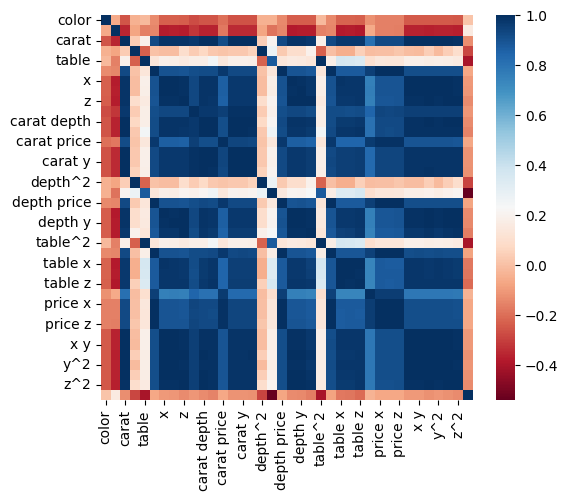

In [9]:
import seaborn as sns

df_temp = pd.concat([X_train, y_train], axis=1)
corr = df_temp.corr()
plt.figure(figsize=(6, 5))
sns.heatmap(corr, cmap="RdBu")
plt.show()

As expected, variations of each feature (eg. x, x^2, xy...) have high correlation between themselves.

In [10]:
model = LogReg()
model.cross_validation(X_train, y_train, 5, 0.2)

Performing cross validation


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   11.5s remaining:   17.3s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   11.5s remaining:    7.7s


Cross validation (accuracy) scores:
	mean: 0.7206530395540217 std: 0.0012830417811090684


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   12.9s finished


In [11]:
X_train2, X_val, y_train2, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
model.fit(X_train2, y_train2)
model.compute_metrics(X_val, y_val)

{'accuracy': 0.7195380939739846,
 'precision': 0.6663310111772983,
 'recall': 0.5411539398791363,
 'f1': 0.5663276422656792}

Altough the accuracy did increase a bit, the recall remains low. We will try to project the features up to degree 3, and see if something improves.

In [12]:
X_train, X_test, y_train, y_test = utils.preprocessing_PLOS(df, degree=3)
X_train.shape

(37666, 121)

In [13]:
model = LogReg()
model.cross_validation(X_train, y_train, 5, 0.2)

Performing cross validation


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   36.3s remaining:   54.6s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   36.5s remaining:   24.3s


Cross validation (accuracy) scores:
	mean: 0.7361826387045394 std: 0.002456933573064321


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   37.5s finished


In [14]:
X_train2, X_val, y_train2, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
model.fit(X_train2, y_train2)
model.compute_metrics(X_val, y_val)

{'accuracy': 0.733342182107778,
 'precision': 0.6354377268498388,
 'recall': 0.5487303933004877,
 'f1': 0.5690398835442465}

Recall stays low, so we will make sure that all classes are predicted with a similar distribution as they have in the training set.

In [15]:
result_df = pd.DataFrame({"y_val": y_val, "y_pred": model.predict(X_val)})
result_counts = result_df.apply(pd.Series.value_counts)
result_counts

,y_val,y_pred
4,3213,3730
3,1898,1935
2,1792,1418
1,580,440
0,51,11


The cause for a low recall could be that classes 0 - 2 (specially 0) are being predicted with less frequency than they should. To solve that, we will set the `class_weight` parameter to `balanced`.

In [16]:
model2 = LogReg(class_weight="balanced")
model2.cross_validation(X_train, y_train, 5, 0.2)

Performing cross validation


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   41.5s remaining:  1.0min


Cross validation (accuracy) scores:
	mean: 0.6840456596761348 std: 0.0021948528387145706


[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   41.8s remaining:   27.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   41.9s finished


In [17]:
model2.fit(X_train2, y_train2)
model2.compute_metrics(X_val, y_val)

{'accuracy': 0.683567825856119,
 'precision': 0.533108437774479,
 'recall': 0.6552642928623654,
 'f1': 0.5496710468092081}

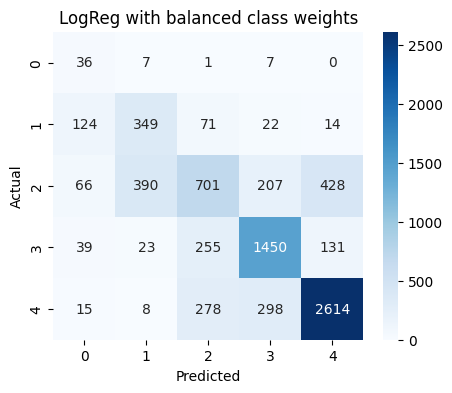

In [18]:
plt.figure(figsize=(5, 4))
sns.heatmap(model2.conf_matrix(X_val, y_val), annot=True, cmap="Blues", fmt="g")
plt.title("LogReg with balanced class weights")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [19]:
result_df = pd.DataFrame({"y_val": y_val, "y_pred": model2.predict(X_val)})
result_counts = result_df.apply(pd.Series.value_counts)
result_counts

,y_val,y_pred
4,3213,3187
3,1898,1984
2,1792,1306
1,580,777
0,51,280


We got a significant decrease in precision. Moreover, we observe that, despite training the model with balanced importance of the classes, class 0 is now overpredicted. Now we compare it with the previous model (which had no class weigths).

In [20]:
diff = model2.compare(model, X_val, y_val)

accuracy -0.04977435625165905
precision -0.10232928907535976
recall 0.10653389956187775
f1 -0.01936883673503842
confusion matrix [[  32  -30   -2    0    0]
 [ 117   52 -135  -18  -16]
 [  66  288 -151  -42 -161]
 [  39   22   37  -20  -78]
 [  15    5  139  129 -288]]


All metrics decreased except recall, that increased a bit.

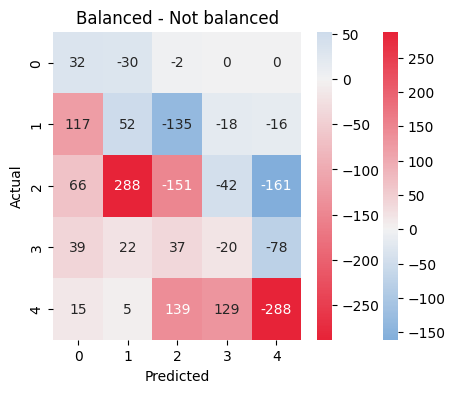

In [21]:
conf_mat_diff = diff["confusion matrix"]

mask = np.eye(conf_mat_diff.shape[0], dtype=bool)
cmap_diag = sns.diverging_palette(250, 10, s=90, l=50, as_cmap=True)
cmap_offdiag = sns.diverging_palette(10, 250, s=90, l=50, as_cmap=True)

plt.figure(figsize=(5, 4))
sns.heatmap(conf_mat_diff, mask=mask, annot=True, fmt="d", cmap=cmap_diag, center=0)
sns.heatmap(conf_mat_diff, mask=~mask, annot=True, fmt="d", cmap=cmap_offdiag, center=0)
plt.title("Balanced - Not balanced")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

The difference confusion matrix shows that the actual class 0 was much more correctly predicted (look at first row), but because the model had a trend to predict all classes as 0 more often (look at first column).  
Another observation is that class 2 was less predicted as being class 3 or 4, but more at being class 0 or 1, and overall less predicted as the class 2 it was.

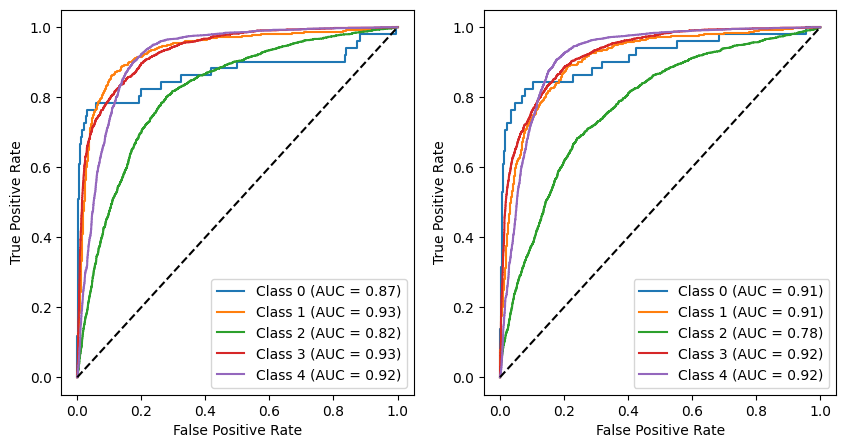

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
model.roc_curve(X_val, y_val, ax[0])
model2.roc_curve(X_val, y_val, ax[1])
plt.show()

We can't see much difference in the ROC curves of both, except the two ovservations we've just made with the difference confusion matrix: class 0 is better predicted and class 2 is worse predicted.  
We conclude it's not worth to set `class_weigth = "balanced"`.

In [23]:
X_train, X_test, y_train, y_test = utils.preprocessing_PLOS(df, degree=3)
X_train2, X_val, y_train2, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
model = LogReg()
model.fit(X_train2, y_train2)
model.compute_metrics(X_val, y_val)

{'accuracy': 0.733342182107778,
 'precision': 0.6354377268498388,
 'recall': 0.5487303933004877,
 'f1': 0.5690398835442465}

### With outliers
As an ablation study, this time we will train the model with outliers. We won't change the parameters. Before, doing so didn't modify much the performance, so we asume it's not necessary to do it this time.

In [30]:
X_train, X_test, y_train, y_test = utils.preprocessing_PLS(df, degree=3)
X_train2, X_val, y_train2, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
model = LogReg()
model.cross_validation(X_train, y_train, 5, 0.2)

Performing cross validation


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   50.5s remaining:  1.3min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   52.1s remaining:   34.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   52.1s finished


Cross validation (accuracy) scores:
	mean: 0.7186884486154559 std: 0.0025394541893727085


In [28]:
model.fit(X_train2, y_train2)
model.compute_metrics(X_val, y_val)

{'accuracy': 0.7103464256748928,
 'precision': 0.7257996794679715,
 'recall': 0.6471759991645833,
 'f1': 0.675616176022558}

We can directly see that all metrics except for accuracy increased. We will continue with this approach.

### Final test

In [2]:
X_train, X_test, y_train, y_test = utils.preprocessing_PLS(df, degree=3)
model = LogReg(class_weight="balanced")
model.fit(X_train, y_train)
model.compute_metrics(X_test, y_test)

{'accuracy': 0.7048572487949574,
 'precision': 0.6582827454759675,
 'recall': 0.7077109657942993,
 'f1': 0.6784303465104282}

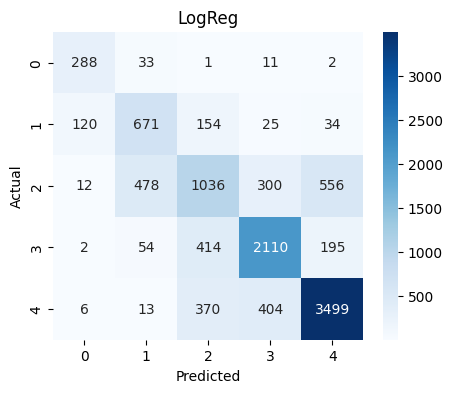

In [3]:
plt.figure(figsize=(5, 4))
sns.heatmap(model.conf_matrix(X_test, y_test), annot=True, cmap="Blues", fmt="g")
plt.title("LogReg")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

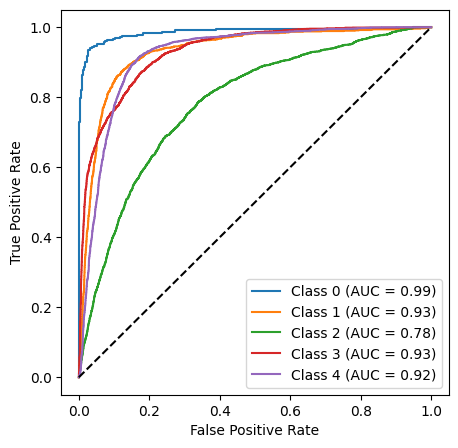

In [4]:
model.roc_curve(X_test, y_test)